In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [2]:
PATTERNS = {
    'requested': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.cluster.k8s.ExecutorPodsAllocator\s-\sGoing\sto\srequest\s(\d+)\sexecutors',
    'request_deleted': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.cluster.k8s.ExecutorPodsAllocator\s-\sDeleting\s(\d+)\sexcess\spod\srequests',
    'registered': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.dynalloc.ExecutorMonitor\s-\sNew executor \d+ has registered \(new total is (\d+)\)',
    'removed': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.dynalloc.ExecutorMonitor\s-\sExecutor \d+ is removed',
    'kill_request': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.cluster.k8s.KubernetesClusterSchedulerBackend\s-\sRequesting to kill executor\(s\) (.+)$',
    'end': r'^(\d+)\sWORKLOAD_END$'
}

DIR_LOGS = '../data/dynalloc-logs'

In [3]:
def get_converted_time(timestamp, start_time):
    return int(timestamp) / 1000 - start_time 

In [4]:
def get_requests(log, start_time):

    def get_time(timestamp):
        return get_converted_time(timestamp, start_time)

    matches = re.finditer(PATTERNS['requested'], log, re.MULTILINE)
    requests = []
    for match in matches:
        time, count = match.groups()
        requests.append((get_time(time), int(count)))
    
    matches = re.finditer(PATTERNS['request_deleted'], log, re.MULTILINE)
    for match in matches:
        time, count = match.groups()
        requests.append((get_time(time), -int(count)))

    matches = re.finditer(PATTERNS['kill_request'], log, re.MULTILINE)
    for match in matches:
        time, list = match.groups()
        count = len(list.split(','))
        requests.append((get_time(time), -count))
    
    return(sorted(requests))

In [5]:
def get_registered(log, start_time):

    def get_time(timestamp):
        return get_converted_time(timestamp, start_time)
    
    matches = re.finditer(PATTERNS['registered'], log, re.MULTILINE)
    registered = []

    for match in matches:
        time, total = match.groups()
        registered.append((get_time(time), +1))
    
    matches = re.finditer(PATTERNS['removed'], log, re.MULTILINE)
    for match in matches:
        time, = match.groups()
        registered.append((get_time(time), -1))

    return(sorted(registered))


In [6]:
def get_end(log, start_time):

    matches = re.finditer(PATTERNS['end'], log, re.MULTILINE)
    matches = list(matches)

    time = None

    # should never be more than one, but if so, take the last one.
    # alternative: raise exception?
    for match in matches:
        time, = match.groups()
        time = get_converted_time(time, start_time)
    
    return time


In [7]:
def get_timeline(changes, end_time=None):
    total = 0
    timeline = []
    if len(changes) > 0:
        first_time, first_delta = changes[0]
        last_time = first_time - 1
        for time, delta in changes:
            if (time != last_time):
                timeline.append((last_time, total))
                if (time - last_time > 1):
                    timeline.append((time - 1, total))
                last_time = time
            total += delta
        timeline.append((last_time, total))

        if end_time != None:
            if (end_time > last_time):
                timeline.append((end_time - 1, total))
                timeline.append((end_time, 0))
                
    return timeline

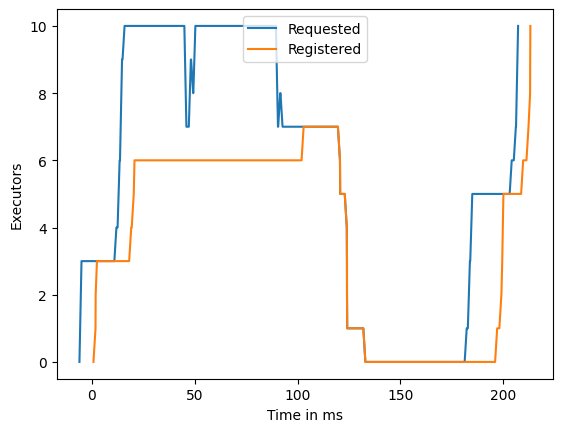

In [9]:
# Sample log line for demonstration
with open('../out.txt', 'r') as file:
    log = file.read()

start_time = 1718289755

requests = get_requests(log, start_time)
registered = get_registered(log, start_time)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel(f'Time in ms')
ax.set_ylabel('Executors')

for type in [(requests, 'Requested'), (registered, 'Registered')]:
    data, name = type
    timeline = get_timeline(data, -10)
    
    x, y = zip(*timeline)
    ax.plot(x, y, label=name)

ax.legend()

In [8]:
def plot_executors(workload, time, start_offset=0):

    time = int(time)

    dir = f"{DIR_LOGS}/{workload}/{time}"
    file_list = os.listdir(dir)

    logs = {}

    for filename in file_list:
        if filename.endswith('.log'):
            with open(f'{dir}/{filename}', 'r') as file:
                content = file.read()
                logs[filename.strip('.log')] = content

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(20)
    ax.set_xlabel(f'Time in Seconds')
    ax.set_ylabel('Executors')

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = iter(prop_cycle.by_key()['color'])

    for app in sorted(logs.keys()):
        end_time = get_end(logs[app], time)

        requests = get_requests(logs[app], time)
        registered = get_registered(logs[app], time)
        requests_timeline = get_timeline(requests, end_time)
        registered_timeline = get_timeline(registered, end_time)

        requests_x, requests_y = zip(*requests_timeline)
        registered_x, registered_y = zip(*registered_timeline)
        color = next(colors)
        ax.plot(requests_x, requests_y, color=color, linestyle='dashed', label=f'App {app} - Requested')
        ax.plot(registered_x, registered_y, color=color, label=f'App {app} - Registered')

    ax.legend()
        

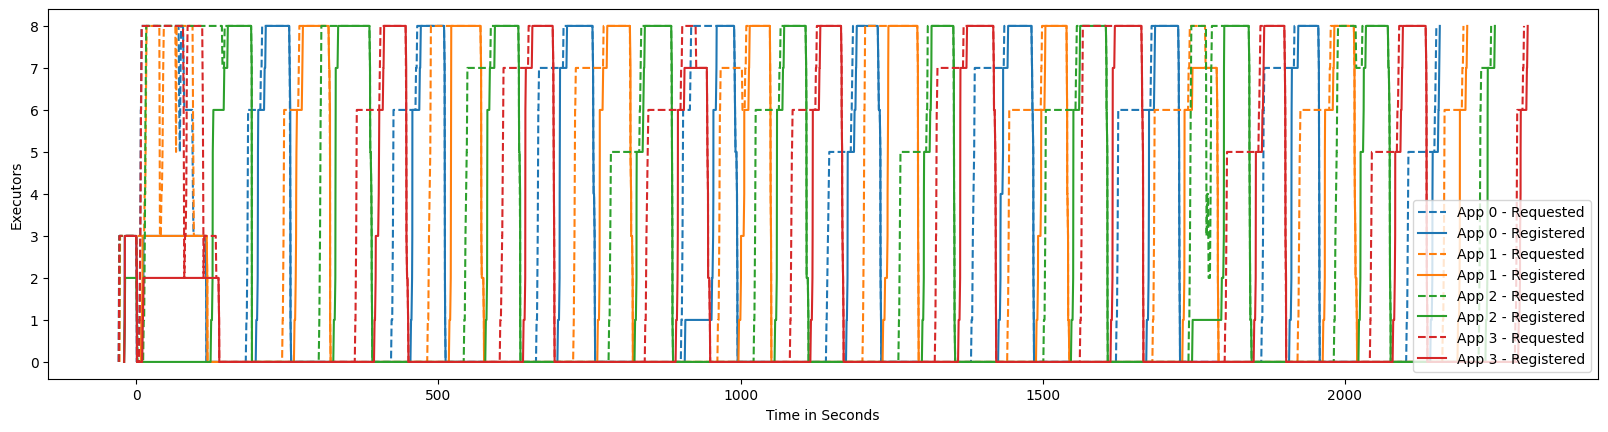

In [9]:
plot_executors('bursty-spaced-i4d60s600_4', '1718301841')